*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Truss in the System

In this chapter, we'll use systems of linear equations to analyze trusses.

A **truss** is an assembly of beams connected by joints, usually designed to support a load. Many bridges and roofs are supported by trusses, and if you've ever participated in a model bridge competition, the structure you built was probably a truss.

This picture shows a **Warren truss**, the basis of many railroad bridge designs:

<img width="400" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/VIEW_OF_BRIDGE_FROM_SOUTH_WITH_ONCOMING_CSX_LOCOMOTIVE_ON_TRACKS_BELOW%2C_LOOKING_NORTHEAST_-_Wills_Creek_Bollman_Bridge%2C_Spanning_CSX_tracks_at_T381%2C_Meyersdale%2C_Somerset_County%2C_HAER_PA%2C56-MEYER.V%2C2-2.tif/lossy-page1-800px-thumbnail.tif.jpg">

This structure is made of three connected triangles with horizontal beams across the top. It's supported by anchor points at each end, and it carries a deck that supports a roadway. The load on the truss includes the weight of the roadway, any vehicles on it, and the weight of the truss itself.

To model a structure like this, we'll make some simplifying assumptions:

- We'll treat the structure as two-dimensional, analyzing only one side of the truss.

- We'll assume the joints behave like **hinge pins** that connect members but allow them to rotate freely.

- We'll assume the load is applied only at the joints, not along the length of the members.

- We'll treat each member of the truss as a **spring** that pushes or pulls in response to stretching or compression, with force that depends on its size and material.

These assumptions aren't fully realistic, but they're reasonable approximations.
With them, we can analyze the structure -- that is, for a given load, we can compute how much each member stretches or compresses, and how much force it exerts in response.

The goal is to find an **equilibrium**, where the external forces applied to the truss are exactly balanced by internal forces in the members.

As always with this kind of model, the hope is that even with simplifications, the results we compute will be approximately correct in the real world.

To solve this system, we'll use **projection matrices**, which we saw in Section XXX, and we'll introduce **block matrices**, which are matrices that contain vectors or submatrices as elements.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/nullspace.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate, underride

## Section

In [3]:
# --- Imports ---
import pint
from sympy import symbols, Matrix, sqrt, simplify, Eq, solve

# --- Unit setup ---
ureg = pint.UnitRegistry()

# --- Symbolic variables (global scope) ---
L = symbols('L')
x_C, y_C = symbols('x_C y_C')
E_CA, E_CB = symbols('E_CA E_CB')
A_CA, A_CB = symbols('A_CA A_CB')
F = symbols('F')
u_x, u_y = symbols('u_x u_y')

# --- Position vectors of nodes ---
pos_A = Matrix([0, 0])
pos_B = Matrix([L, 0])
pos_C = Matrix([x_C, y_C])

# --- Displacement vector at node C ---
u_C = Matrix([u_x, u_y])
u_C

Matrix([
[u_x],
[u_y]])

In [4]:
# --- Vectors from node C to A and B ---
r_CA = pos_A - pos_C
r_CB = pos_B - pos_C

# --- Stiffnesses (scalar) ---
L_CA = r_CA.norm()
L_CB = r_CB.norm()

k_CA = E_CA * A_CA / L_CA
k_CB = E_CB * A_CB / L_CB
k_CA

A_CA*E_CA/sqrt(Abs(x_C)**2 + Abs(y_C)**2)

In [5]:
# --- Projector helper ---
def projector(r):
    rhat = r.normalized()
    return rhat * rhat.T

# --- Projection matrices ---
P_CA = projector(r_CA)
P_CB = projector(r_CB)

# Optional: display the matrices
print("P_CA (projection onto direction CA):")
display(P_CA)

print("P_CB (projection onto direction CB):")
display(P_CB)


P_CA (projection onto direction CA):


Matrix([
[ x_C**2/(Abs(x_C)**2 + Abs(y_C)**2), x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)],
[x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2),  y_C**2/(Abs(x_C)**2 + Abs(y_C)**2)]])

P_CB (projection onto direction CB):


Matrix([
[  (L - x_C)**2/(Abs(y_C)**2 + Abs(L - x_C)**2), -y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)],
[-y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2),         y_C**2/(Abs(y_C)**2 + Abs(L - x_C)**2)]])

In [6]:
K = k_CA * P_CA + k_CB * P_CB
K

Matrix([
[  A_CA*E_CA*x_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*(L - x_C)**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2), A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)],
[A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2),         A_CA*E_CA*y_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*y_C**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)]])

In [7]:
# External force vector
f_ext = Matrix([0, -F])

eq = sp.Eq(K * u_C, f_ext)
eq

Eq(Matrix([
[u_x*(A_CA*E_CA*x_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*(L - x_C)**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)) + u_y*(A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2))],
[      u_x*(A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)) + u_y*(A_CA*E_CA*y_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*y_C**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2))]]), Matrix([
[ 0],
[-F]]))

In [8]:
# --- Numerical parameters (Pint quantities) ---
params = {
    'L': 15.0 * ureg.cm,
    'x_C': 15.0 / 2 * ureg.cm,
    'y_C': np.sqrt(3) * 15.0 / 2 * ureg.cm,
    'A_CA': 1.0 * ureg.cm * 0.2 * ureg.cm,
    'A_CB': 1.0 * ureg.cm * 0.2 * ureg.cm,
    'E_CA': 3.0e9 * ureg.Pa,
    'E_CB': 2.0e9 * ureg.Pa,
    'F': 9.8 * ureg.newton,
}

In [9]:
def make_subs(symbols, quantities):
    """Make a dictionary that maps from symbols to quantities.
    """
    return {sym: quantities[sym.name].to_base_units().magnitude for sym in symbols}

In [10]:
symbols_to_sub = [L, x_C, y_C, A_CA, A_CB, E_CA, E_CB, F]
subs = make_subs(symbols_to_sub, params)
subs

{L: 0.15,
 x_C: 0.075,
 y_C: np.float64(0.12990381056766578),
 A_CA: 2e-05,
 A_CB: 2e-05,
 E_CA: 3000000000.0,
 E_CB: 2000000000.0,
 F: 9.8}

In [11]:
def sympy_to_numpy(expr):
    """
    Substitute values into a SymPy expression or matrix and return a NumPy array of floats.

    Args:
        expr: A SymPy Matrix or expression.

    Returns:
        NumPy array with float dtype.
    """
    evaluated = expr.evalf()
    if isinstance(evaluated, sp.MatrixBase):
        return np.array(evaluated.tolist(), dtype=float)
    else:
        return float(evaluated)


K_np = sympy_to_numpy(K.subs(subs))
K_np

array([[166666.66666667,  57735.02691896],
       [ 57735.02691896, 500000.        ]])

Interpret the components.

In [12]:
u_example = np.array([7, -20]) * 1e-6
F_example = -K_np @ u_example
F_example

array([-0.01196613,  9.59585481])

So multiplying by K is a function that takes a displacement vector and returns a force vector.

In [13]:
eqs_num = eq.subs(subs)
eqs_num

Eq(Matrix([
[166666.666666667*u_x + 57735.0269189626*u_y],
[        57735.0269189626*u_x + 500000.0*u_y]]), Matrix([
[   0],
[-9.8]]))

In [14]:
sol = solve(eqs_num, (u_x, u_y))
sol

{u_x: 7.07254079757292e-6, u_y: -2.04166666666667e-5}

In [15]:
u_sol_np = np.array([sol[u_x], sol[u_y]], dtype=float)
u_sol_np

array([ 7.07254080e-06, -2.04166667e-05])

In [16]:
f_sol_np = K_np @ u_sol_np

In [17]:
u_example = u_sol_np

In [18]:
f_example = f_sol_np

## Draw the Force Field

In [19]:
scale = 1e-6
bound = 21
x_vals = np.linspace(-bound, bound, 11) * scale
y_vals = np.linspace(-bound, bound, 11) * scale
x_vals

array([-2.10e-05, -1.68e-05, -1.26e-05, -8.40e-06, -4.20e-06,  0.00e+00,
        4.20e-06,  8.40e-06,  1.26e-05,  1.68e-05,  2.10e-05])

In [20]:
pairs = [(x, y) for x in x_vals for y in y_vals]
U = np.array(pairs).T 
U.shape

(2, 121)

In [21]:
X, Y = np.meshgrid(x_vals, y_vals, indexing='ij')

In [22]:
X.shape

(11, 11)

In [23]:
X.ravel().shape

(121,)

In [24]:
U2 = np.vstack([X.ravel(), Y.ravel()])
np.allclose(U, U2)

True

Either way, U is matrix-like in the sense that it has two dimensions, but we are using it as a collection of vectors, so

In [25]:
F_field = -K_np @ U  # matrix of column force vectors
F_field.shape

(2, 121)

In [26]:
import matplotlib.lines as mlines

def outline_truss():

    # Get current axis
    ax = plt.gca()

    # Define endpoints of truss members (undisplaced)
    truss_left = np.array([-1, -1])   # lower left
    truss_right = np.array([1, -1])   # lower right
    joint = np.array([0, 0])          # shared node

    options = dict(
        linewidth=20,
        solid_capstyle='round',
        color='lightgray',
        alpha=0.5,
        transform=ax.transData
    )
    
    for start in [truss_left, truss_right]:
        line = mlines.Line2D([start[0], joint[0]], [start[1], joint[1]], **options)
        ax.add_artist(line)


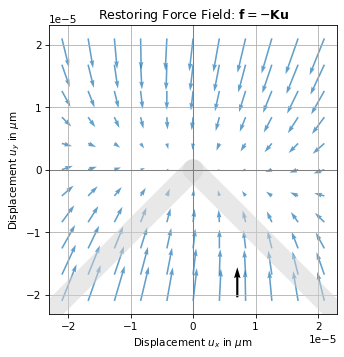

In [27]:
plt.figure(figsize=(5, 5))
outline_truss()

options = dict(angles='xy', scale_units='xy', scale=2e6)

plt.quiver(U[0], U[1], F_field[0], F_field[1], color='C0', alpha=0.7, **options)

plt.quiver(u_example[0], u_example[1], 
           F_example[0], F_example[1], lw=3,
           **options)

plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.gca().set_aspect('equal')

plt.xlabel('Displacement $u_x$ in $\mu$m')
plt.ylabel('Displacement $u_y$ in $\mu$m')
plt.title('Restoring Force Field: $\\mathbf{f} = -\\mathbf{K} \\mathbf{u}$')
plt.grid(True)
None

Discussion: This -- disappointingly -- is what a force field really is. Much less cool than we hoped. It's an example of a vector field, which is a mapping from each point in a space to a vector.



## Truss

In [29]:
def make_vector(x, y, **kwargs):
    return sp.ImmutableDenseMatrix([[x], [y]])

In [30]:
def gset(G, item=None, **kwargs):
    """Set attributes on a node, edge, or the graph itself.

    Args:
        G: A NetworkX graph.
        item: Node ID, edge tuple (u, v), or None for the graph itself.
        **kwargs: Arbitrary key-value pairs to set as attributes.
    """
    if item is None:
        container = G.graph
    elif isinstance(item, tuple) and len(item) == 2:
        container = G.edges[item]
    else:
        container = G.nodes[item]

    container.update(**kwargs)


def gget(G, item=None, *keys):
    """Get one or more attributes from a node, edge, or the graph itself.

    Args:
        G: A NetworkX graph.
        item: Node ID, edge tuple (u, v), or None for the graph itself.
        *keys: One or more attribute names.

    Returns:
        A single value if one key is provided, or a tuple of values if multiple.
    """
    if item is None:
        container = G.graph
    elif isinstance(item, tuple) and len(item) == 2:
        container = G.edges[item]
    else:
        container = G.nodes[item]

    if len(keys) == 1:
        return container[keys[0]]
    return tuple(container[key] for key in keys)

In [31]:
N = 2
L = sp.Symbol('L', positive=True)
H = L * sp.sqrt(3) / 2

In [32]:
G = nx.Graph()

Make the bottom row

In [33]:
origin = make_vector(0, 0)

for i in range(N + 1):
    pos = origin + make_vector(i * L, 0)
    G.add_node(f'B{i}', pos=pos)
    if i > 0:
        G.add_edge(f'B{i-1}', f'B{i}')

Identify the fixed points

In [34]:
gset(G, fixed=['B0', f'B{N}'])

Add top nodes and diagonal edges

In [35]:
for i in range(N):
    pos = origin + make_vector((i + 0.5) * L, H)
    G.add_node(f'T{i}', pos=pos)
    G.add_edge(f'B{i}', f'T{i}')
    G.add_edge(f'T{i}', f'B{i+1}')

    if i > 0:
        G.add_edge(f'T{i-1}', f'T{i}')

Add attributes to the edges

In [36]:
E, A = sp.symbols('E A')

for edge in G.edges:
    node1, node2 = edge
    x1 = G.nodes[node1]['pos']
    x2 = G.nodes[node2]['pos']

    r = x2 - x1
    l = r.norm()
    k = E * A / l

    gset(G, edge, E=E, A=A, r=r, l=l, k=k)

In [37]:
def draw_truss(G, subs, label_nodes=True, **options):
    pos = {}
    for node in G.nodes:
        p = gget(G, node, 'pos').subs(subs).evalf()
        pos[node] = [float(x) for x in p]

    underride(options, edge_color='C0')
    nx.draw_networkx_edges(G, pos, width=2, **options)
    if label_nodes:
        node_options = dict(node_size=1000, node_color='white', edgecolors='C0')
        nx.draw_networkx_nodes(G, pos, **node_options)
        nx.draw_networkx_labels(G, pos, font_size=11)

    plt.axis('equal')
    plt.axis('off')

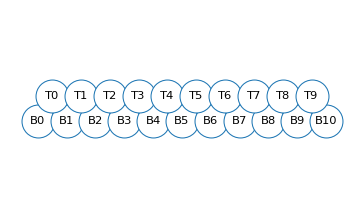

In [38]:
draw_truss(G, {L: 0.15})

Add displacement vectors to the nodes

In [39]:
for node in G.nodes():
    if node in G.graph['fixed']:
        ux, uy = 0, 0
    else:
        ux, uy = sp.symbols(f'u_{node}_x u_{node}_y')
        
    disp = make_vector(ux, uy, name=f'u_{node}')
    gset(G, node, disp=disp)

Assign an external force to each node.

In [40]:
z = make_vector(0, 0)
for i, node in enumerate(G.nodes):
    gset(G, node, f_ext=z)

Hang a weight from the middle node.

In [41]:
f_ext = sp.Symbol('f_ext')
gset(G, 'B1', f_ext=make_vector(0, f_ext))

In [42]:
for i, node in enumerate(G.nodes):
    gset(G, node, index=i)

## Block Matrix Equation


In [43]:
def Ksym(i, j):
    return sp.MatrixSymbol(f'K_{i}{j}', 2, 2)

In [44]:
n = len(G.nodes)
blocks = [[Ksym(i, j) for j in range(n)] for i in range(n)]
K_block = sp.BlockMatrix(blocks)
K_block

Matrix([
[ K_00,  K_01,  K_02,  K_03,  K_04,  K_05,  K_06,  K_07,  K_08,  K_09,  K_010,  K_011,  K_012,  K_013,  K_014,  K_015,  K_016,  K_017,  K_018,  K_019,  K_020],
[ K_10,  K_11,  K_12,  K_13,  K_14,  K_15,  K_16,  K_17,  K_18,  K_19,  K_110,  K_111,  K_112,  K_113,  K_114,  K_115,  K_116,  K_117,  K_118,  K_119,  K_120],
[ K_20,  K_21,  K_22,  K_23,  K_24,  K_25,  K_26,  K_27,  K_28,  K_29,  K_210,  K_211,  K_212,  K_213,  K_214,  K_215,  K_216,  K_217,  K_218,  K_219,  K_220],
[ K_30,  K_31,  K_32,  K_33,  K_34,  K_35,  K_36,  K_37,  K_38,  K_39,  K_310,  K_311,  K_312,  K_313,  K_314,  K_315,  K_316,  K_317,  K_318,  K_319,  K_320],
[ K_40,  K_41,  K_42,  K_43,  K_44,  K_45,  K_46,  K_47,  K_48,  K_49,  K_410,  K_411,  K_412,  K_413,  K_414,  K_415,  K_416,  K_417,  K_418,  K_419,  K_420],
[ K_50,  K_51,  K_52,  K_53,  K_54,  K_55,  K_56,  K_57,  K_58,  K_59,  K_510,  K_511,  K_512,  K_513,  K_514,  K_515,  K_516,  K_517,  K_518,  K_519,  K_520],
[ K_60,  K_61,  K_62,  K_63,  K

In [45]:
blocks = [sp.MatrixSymbol(f'u_{{{node}}}', 2, 1) for node in G.nodes]
u_block = sp.BlockMatrix([[u] for u in blocks])
u_block

Matrix([
[ u_{B0}],
[ u_{B1}],
[ u_{B2}],
[ u_{B3}],
[ u_{B4}],
[ u_{B5}],
[ u_{B6}],
[ u_{B7}],
[ u_{B8}],
[ u_{B9}],
[u_{B10}],
[ u_{T0}],
[ u_{T1}],
[ u_{T2}],
[ u_{T3}],
[ u_{T4}],
[ u_{T5}],
[ u_{T6}],
[ u_{T7}],
[ u_{T8}],
[ u_{T9}]])

In [46]:
blocks = [sp.MatrixSymbol(f'f_{{{node}}}', 2, 1) for node in G.nodes]
f_block = sp.BlockMatrix([[f] for f in blocks])
f_block

Matrix([
[ f_{B0}],
[ f_{B1}],
[ f_{B2}],
[ f_{B3}],
[ f_{B4}],
[ f_{B5}],
[ f_{B6}],
[ f_{B7}],
[ f_{B8}],
[ f_{B9}],
[f_{B10}],
[ f_{T0}],
[ f_{T1}],
[ f_{T2}],
[ f_{T3}],
[ f_{T4}],
[ f_{T5}],
[ f_{T6}],
[ f_{T7}],
[ f_{T8}],
[ f_{T9}]])

In [47]:
equation = sp.Eq(K_block * u_block, f_block)
equation

Eq(Matrix([
[ K_00,  K_01,  K_02,  K_03,  K_04,  K_05,  K_06,  K_07,  K_08,  K_09,  K_010,  K_011,  K_012,  K_013,  K_014,  K_015,  K_016,  K_017,  K_018,  K_019,  K_020],
[ K_10,  K_11,  K_12,  K_13,  K_14,  K_15,  K_16,  K_17,  K_18,  K_19,  K_110,  K_111,  K_112,  K_113,  K_114,  K_115,  K_116,  K_117,  K_118,  K_119,  K_120],
[ K_20,  K_21,  K_22,  K_23,  K_24,  K_25,  K_26,  K_27,  K_28,  K_29,  K_210,  K_211,  K_212,  K_213,  K_214,  K_215,  K_216,  K_217,  K_218,  K_219,  K_220],
[ K_30,  K_31,  K_32,  K_33,  K_34,  K_35,  K_36,  K_37,  K_38,  K_39,  K_310,  K_311,  K_312,  K_313,  K_314,  K_315,  K_316,  K_317,  K_318,  K_319,  K_320],
[ K_40,  K_41,  K_42,  K_43,  K_44,  K_45,  K_46,  K_47,  K_48,  K_49,  K_410,  K_411,  K_412,  K_413,  K_414,  K_415,  K_416,  K_417,  K_418,  K_419,  K_420],
[ K_50,  K_51,  K_52,  K_53,  K_54,  K_55,  K_56,  K_57,  K_58,  K_59,  K_510,  K_511,  K_512,  K_513,  K_514,  K_515,  K_516,  K_517,  K_518,  K_519,  K_520],
[ K_60,  K_61,  K_62,  K_63,

In an ideal world, we would write the equation this way and solve it, but we don't have solvers that can work on a system where the elements are vectors and matrices.


## Compute the Block Matrix

Get the edge properties

In [48]:
edge = 'B1', 'T1'
r, k = gget(G, edge, "r", "k")

Get the displacements of the nodes

In [49]:
node1, node2 = edge
u1 = gget(G, node1, "disp")
u2 = gget(G, node2, "disp")

In [50]:
# Geometry and stiffness    
P = projector(r)

In [51]:
from sympy import MatMul

expr = MatMul(-k * P, u1 - u2, evaluate=False)
expr

Matrix([
[        -0.25*A*E/L, -0.25*sqrt(3)*A*E/L],
[-0.25*sqrt(3)*A*E/L,         -0.75*A*E/L]])*Matrix([
[u_B1_x - u_T1_x],
[u_B1_y - u_T1_y]])

In [52]:
# Internal force
f_int = -k * P * (u1 - u2)
f_int

Matrix([
[-0.25*A*E*(u_B1_x - u_T1_x)/L - 0.25*sqrt(3)*A*E*(u_B1_y - u_T1_y)/L],
[-0.25*sqrt(3)*A*E*(u_B1_x - u_T1_x)/L - 0.75*A*E*(u_B1_y - u_T1_y)/L]])

In [53]:
def compute_kP(G, edge):
    r, k = gget(G, edge, "r", "k")

    # Geometry and stiffness    
    P = projector(r)

    return k * P

In [54]:
def zero_block(size=2):
    return sp.ImmutableMatrix.zeros(size, size)

In [55]:
blocks = [[zero_block() for _ in range(n)] for _ in range(n)]

In [56]:
for edge in G.edges:
    kP = compute_kP(G, edge)
    
    node1, node2 = edge
    i = gget(G, node1, 'index')
    j = gget(G, node2, 'index')

    # Insert contributions for edge (i, j)
    blocks[i][i] +=  kP
    blocks[i][j] += -kP
    blocks[j][i] += -kP
    blocks[j][j] +=  kP

In [57]:
keep = [gget(G, node, 'index') 
        for node in G.nodes 
        if node not in G.graph['fixed']]
keep    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [58]:
blocks_reduced = [
    [blocks[i][j] for j in keep]
    for i in keep
]

In [59]:
K_block = sp.BlockMatrix(blocks_reduced)
K_block

Matrix([
[                                        Matrix([
[2.5*A*E/L,         0],
[        0, 1.5*A*E/L]]),                                                               Matrix([
[-A*E/L, 0],
[     0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]), Matrix([
[       -0.25*A*E/L, 0.25*sqrt(3)*A*E/L],
[0.25*sqrt(3)*A*E/L,        -0.75*A*E/L]]), Matr

In [60]:
def get_block_vector(G, attr, keep):
    blocks = [gget(G, node, attr) for node in G.nodes]
    blocks_reduced = [[blocks[i]] for i in keep]
    return sp.BlockMatrix(blocks_reduced)

In [61]:
u_block = get_block_vector(G, 'disp', keep)
u_block

Matrix([
[Matrix([
[u_B1_x],
[u_B1_y]])],
[Matrix([
[u_B2_x],
[u_B2_y]])],
[Matrix([
[u_B3_x],
[u_B3_y]])],
[Matrix([
[u_B4_x],
[u_B4_y]])],
[Matrix([
[u_B5_x],
[u_B5_y]])],
[Matrix([
[u_B6_x],
[u_B6_y]])],
[Matrix([
[u_B7_x],
[u_B7_y]])],
[Matrix([
[u_B8_x],
[u_B8_y]])],
[Matrix([
[u_B9_x],
[u_B9_y]])],
[Matrix([
[u_T0_x],
[u_T0_y]])],
[Matrix([
[u_T1_x],
[u_T1_y]])],
[Matrix([
[u_T2_x],
[u_T2_y]])],
[Matrix([
[u_T3_x],
[u_T3_y]])],
[Matrix([
[u_T4_x],
[u_T4_y]])],
[Matrix([
[u_T5_x],
[u_T5_y]])],
[Matrix([
[u_T6_x],
[u_T6_y]])],
[Matrix([
[u_T7_x],
[u_T7_y]])],
[Matrix([
[u_T8_x],
[u_T8_y]])],
[Matrix([
[u_T9_x],
[u_T9_y]])]])

In [62]:
f_block = get_block_vector(G, 'f_ext', keep)
f_block

Matrix([
[Matrix([
[    0],
[f_ext]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])]])

## Make the arrays explicit

In [63]:
K_dense = K_block.as_explicit()
K_dense

Matrix([
[          2.5*A*E/L,                   0,              -A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,        -0.25*A*E/L, 0.25*sqrt(3)*A*E/L,         -0.25*A*E/L, -0.25*sqrt(3)*A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0],
[                  0,           1.5*A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0,    

In [64]:
u_dense = u_block.as_explicit()

In [65]:
f_dense = f_block.as_explicit()

In [66]:
Eq(MatMul(K_dense, u_dense, evaluate=False), f_dense)

Eq(Matrix([
[          2.5*A*E/L,                   0,              -A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,        -0.25*A*E/L, 0.25*sqrt(3)*A*E/L,         -0.25*A*E/L, -0.25*sqrt(3)*A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0],
[                  0,           1.5*A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0, 

In [67]:
eq = Eq(K_dense * u_dense, f_dense)

In [68]:
params = {
    'L': 15.0 * ureg.cm,
    'A': 1.0 * ureg.cm * 0.2 * ureg.cm,
    'E': 3.0e9 * ureg.Pa,
    'f_ext': -9.8 * ureg.newton,
}

In [69]:
symbols = [L, A, E, f_ext]
subs = make_subs(symbols, params)

In [70]:
eqs_num = eq.subs(subs)

In [71]:
sol = solve(eqs_num, u_dense)
sol

{u_B1_x: 0.0,
 u_B1_y: -0.000171500000000000,
 u_B2_x: 1.13160652761167e-5,
 u_B2_y: -0.000241733333333333,
 u_B3_x: 1.98031142332042e-5,
 u_B3_y: -0.000274400000000000,
 u_B4_x: 2.54611468712625e-5,
 u_B4_y: -0.000276033333333333,
 u_B5_x: 2.82901631902917e-5,
 u_B5_y: -0.000253166666666667,
 u_B6_x: 2.82901631902917e-5,
 u_B6_y: -0.000212333333333333,
 u_B7_x: 2.54611468712625e-5,
 u_B7_y: -0.000160066666666667,
 u_B8_x: 1.98031142332042e-5,
 u_B8_y: -0.000102900000000000,
 u_B9_x: 1.13160652761167e-5,
 u_B9_y: -4.73666666666667e-5,
 u_T0_x: 9.76010630065062e-5,
 u_T0_y: -8.57500000000000e-5,
 u_T1_x: 7.21399161352437e-5,
 u_T1_y: -0.000209883333333333,
 u_T2_x: 4.95077855830104e-5,
 u_T2_y: -0.000260516666666667,
 u_T3_x: 2.97046713498062e-5,
 u_T3_y: -0.000276850000000000,
 u_T4_x: 1.27305734356312e-5,
 u_T4_y: -0.000265416666666667,
 u_T5_x: -1.41450815951458e-6,
 u_T5_y: -0.000232750000000000,
 u_T6_x: -1.27305734356312e-5,
 u_T6_y: -0.000185383333333333,
 u_T7_x: -2.121762239271

In [72]:
Eq(u_block, u_block.subs(sol))

Eq(Matrix([
[Matrix([
[u_B1_x],
[u_B1_y]])],
[Matrix([
[u_B2_x],
[u_B2_y]])],
[Matrix([
[u_B3_x],
[u_B3_y]])],
[Matrix([
[u_B4_x],
[u_B4_y]])],
[Matrix([
[u_B5_x],
[u_B5_y]])],
[Matrix([
[u_B6_x],
[u_B6_y]])],
[Matrix([
[u_B7_x],
[u_B7_y]])],
[Matrix([
[u_B8_x],
[u_B8_y]])],
[Matrix([
[u_B9_x],
[u_B9_y]])],
[Matrix([
[u_T0_x],
[u_T0_y]])],
[Matrix([
[u_T1_x],
[u_T1_y]])],
[Matrix([
[u_T2_x],
[u_T2_y]])],
[Matrix([
[u_T3_x],
[u_T3_y]])],
[Matrix([
[u_T4_x],
[u_T4_y]])],
[Matrix([
[u_T5_x],
[u_T5_y]])],
[Matrix([
[u_T6_x],
[u_T6_y]])],
[Matrix([
[u_T7_x],
[u_T7_y]])],
[Matrix([
[u_T8_x],
[u_T8_y]])],
[Matrix([
[u_T9_x],
[u_T9_y]])]]), Matrix([
[                      Matrix([
[       0.0],
[-0.0001715]])],
[Matrix([
[  1.13160652761167e-5],
[-0.000241733333333333]])],
[    Matrix([
[1.98031142332042e-5],
[         -0.0002744]])],
[Matrix([
[  2.54611468712625e-5],
[-0.000276033333333333]])],
[Matrix([
[  2.82901631902917e-5],
[-0.000253166666666667]])],
[Matrix([
[  2.82901631902917e-5],


In [73]:
G_sol = G.copy()
scale = 300

for node in G_sol.nodes:
    pos = gget(G_sol, node, 'pos')
    u = gget(G_sol, node, 'disp')
    u_eval = u.subs(sol).evalf() * scale
    pos_new = pos + u_eval
    gset(G_sol, node, pos=pos_new)

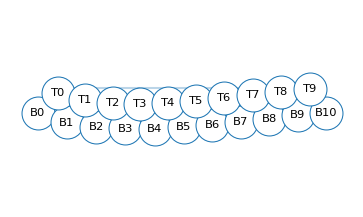

In [74]:
subs = {L: 0.15}
draw_truss(G, subs, label_nodes=False, alpha=0.3)
draw_truss(G_sol, subs)

## Discussion

When I was an undergraduate, I took a class where we learned to analyze trusses.
One of my classmates asked a question that I'm not sure I appreciated at the time, but it has stuck with me.
To paraphrase, he asked, "Do we design trusses because they are optimal, or because they are easy to analyze?"
I have come to realize tat this is a really good question.

As you might guess, the answer is both.
If your goal is to build a structure that supports a given load with a minimum amount of material, a truss may not be optimal -- with the complexity of real-world requirements and constraints, it's  generally impossible say what "optimal" even means.
But for many applications, a truss is a fundamentally good design.

It is also easy to analyze, but that is not as important as it used to be.
Before we had computers, we analyzed structures by hand, so we had to keep them simple.
When I was an undergraduate, we had enough compute power and software capability to analyze more complex structures, but what we could design was still limited by what we could analyze.

Now it is possible to analyze almost anything we can imagine, so analysis is no longer the limiting factor on what we can design and build.
But this is a recent change, and we are only beginning to see its consequences.

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)